# RNN on a Time Series

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/drive')

Mounted at /drive


## Part One

**Fetching Data, Spliting it and then creating a Generator**

In [130]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/Deep Learning Course (Jose Portilia)/6. Recurrent Neural Network/RSCCASN.csv')

In [131]:
df.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [132]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334 entries, 0 to 333
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   DATE     334 non-null    object
 1   RSCCASN  334 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.3+ KB


Date is a column and Date is supposed to DateTime object instead of String so a little change here

In [133]:
df = pd.read_csv('/drive/My Drive/Colab Notebooks/Deep Learning Course (Jose Portilia)/6. Recurrent Neural Network/RSCCASN.csv', parse_dates = True, index_col = 'DATE')

In [134]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [135]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [136]:
df.columns = ['Sales']

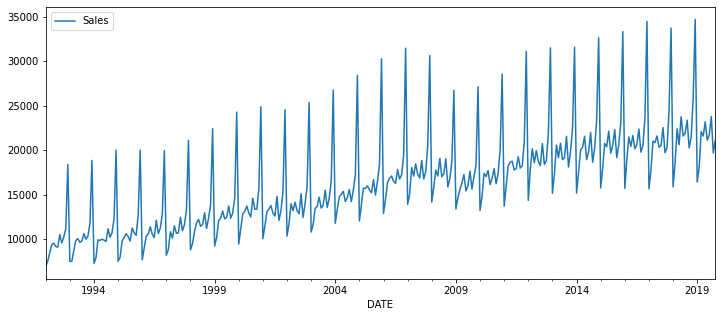

In [137]:
df.plot(figsize = (12, 5))

### Splitting Data

In [138]:
len(df)

334

In [139]:
len(df)/12

27.833333333333332

In [140]:
len(df) - 18 # 18 because 1.5 year

316

In [141]:
test_size = 18
test_ind = len(df) - test_size

In [142]:
train = df[:test_ind]
test = df[test_ind:]

### Scaling Data

In [143]:
from sklearn.preprocessing import MinMaxScaler

In [144]:
scaler = MinMaxScaler()

In [145]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

### Creating Generator

In [146]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [147]:
len(test)

18

In [148]:
length = 12

generator = TimeseriesGenerator(data = train_scaled, targets = train_scaled, length = length, batch_size = 1)

In [149]:
X, y = generator[0]

In [150]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [151]:
y

array([[0.02047633]])

In [152]:
train_scaled[:13]

array([[0.        ],
       [0.02127505],
       [0.05580163],
       [0.08942056],
       [0.09512053],
       [0.08146965],
       [0.07860151],
       [0.12979233],
       [0.09566512],
       [0.1203892 ],
       [0.15426227],
       [0.41595266],
       [0.02047633]])

## Part Two

In [153]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

### Creating a Model

In [154]:
n_features = 1 ## since we only have one feature

In [155]:
model = Sequential()

model.add(LSTM(units = 100, input_shape = (length, n_features), activation = 'relu'))

model.add(Dense(units = 1))

model.compile(loss = 'mse', optimizer = 'adam')

In [156]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               40800     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


#### EarlyStopping

In [157]:
from tensorflow.keras.callbacks import EarlyStopping

In [158]:
earlystop = EarlyStopping(monitor = 'val_loss', patience = 2)

### Creating Validation Generator

In [159]:
validation_generator = TimeseriesGenerator(data = test_scaled, targets = test_scaled, length = length, batch_size = 1)

### Training Model

In [160]:
model.fit(generator, epochs = 20, validation_data = validation_generator, callbacks = [earlystop])

Epoch 1/20
304/304 [==============================] - 3s 7ms/step - loss: 0.0232 - val_loss: 0.0121
Epoch 2/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0174 - val_loss: 0.0031
Epoch 3/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0106 - val_loss: 0.0154
Epoch 4/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0048 - val_loss: 9.8121e-04
Epoch 5/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 6/20
304/304 [==============================] - 2s 6ms/step - loss: 0.0017 - val_loss: 0.0020


### Evaluation

In [161]:
losses = pd.DataFrame(model.history.history)

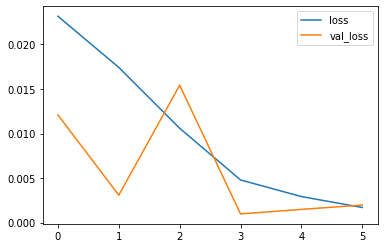

In [162]:
losses.plot()

In [163]:
test_predictions = []
first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for i in range(len(test)):

  current_prediction = model.predict(current_batch)[0]

  test_predictions.append(current_prediction)

  current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

In [164]:
true_predictions = scaler.inverse_transform(test_predictions)

In [165]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [166]:
test.head()

,Sales,Predictions
DATE,,
2018-05-01,23764,22164.242746
2018-06-01,21589,21073.352184
2018-07-01,21919,21366.030300
2018-08-01,23381,23236.308999
2018-09-01,20260,20765.162811


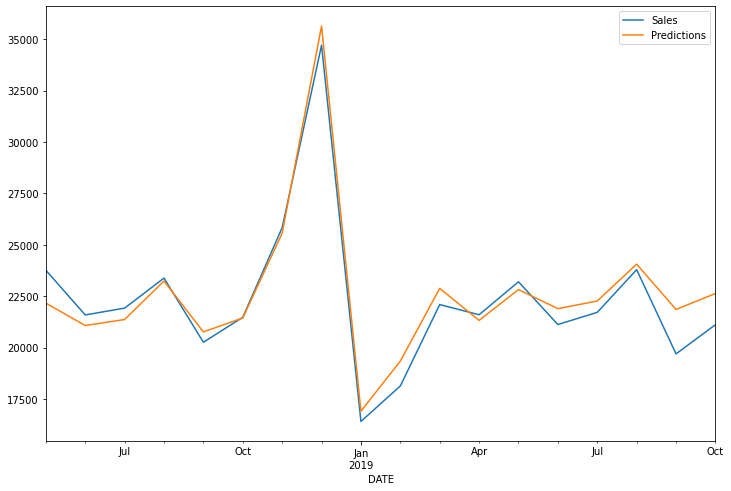

In [167]:
test.plot(figsize = (12, 8))

### Forecasting on Forecast

In [168]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [169]:
length = 12

generator = TimeseriesGenerator(data = scaled_full_data, targets = scaled_full_data, length = length, batch_size = 1)

In [170]:
model = Sequential()

model.add(LSTM(units = 100, input_shape = (length, n_features), activation = 'relu'))

model.add(Dense(units = 1))

model.compile(loss = 'mse', optimizer = 'adam')

model.fit(generator, epochs = 8)

Epoch 1/8
322/322 [==============================] - 3s 6ms/step - loss: 0.0263
Epoch 2/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0178
Epoch 3/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0104
Epoch 4/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0038
Epoch 5/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0042
Epoch 6/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0022
Epoch 7/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0016
Epoch 8/8
322/322 [==============================] - 2s 6ms/step - loss: 0.0011


In [171]:
forecast = []

periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape(1, length, n_features)

for i in range(periods):

  current_prediction = model.predict(current_batch)[0]

  forecast.append(current_prediction)

  current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

In [172]:
forecast = scaler.inverse_transform(forecast)

In [173]:
forecast

array([[26541.89285421],
       [36859.02464104],
       [16788.30336237],
       [18508.34220457],
       [22249.88301086],
       [21849.13996267],
       [23484.6811986 ],
       [21469.37684202],
       [22107.29206896],
       [24186.41290283],
       [20320.43398809],
       [21755.99361563]])

In [174]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq = 'MS')

In [175]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [176]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [177]:
forecast_df

,Forecast
2019-11-01,26541.892854
2019-12-01,36859.024641
2020-01-01,16788.303362
2020-02-01,18508.342205
2020-03-01,22249.883011
2020-04-01,21849.139963
2020-05-01,23484.681199
2020-06-01,21469.376842
2020-07-01,22107.292069
2020-08-01,24186.412903


(576.0, 611.0)

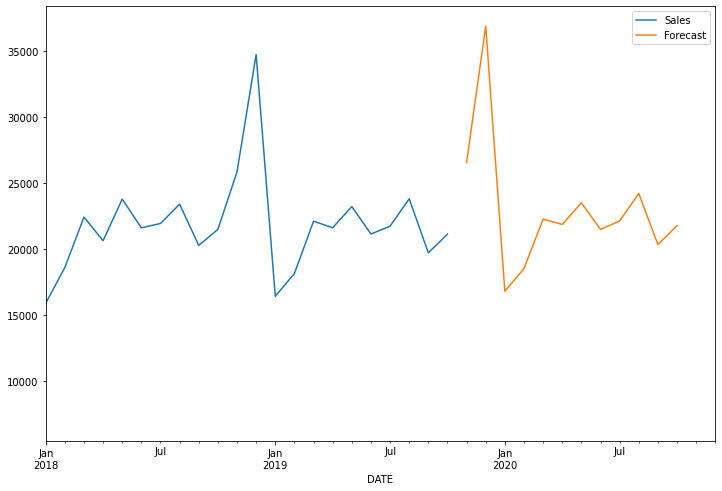

In [178]:
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (12, 8))
plt.xlim('2018-01-01', '2020-12-01')

#### Removing that cut off from Plot

In [179]:
forecast_df.columns = ['Sales']
final_df = pd.concat([df, forecast_df], axis = 0)

In [180]:
final_df

,Sales
1992-01-01,6938.000000
1992-02-01,7524.000000
1992-03-01,8475.000000
1992-04-01,9401.000000
1992-05-01,9558.000000
...,...
2020-06-01,21469.376842
2020-07-01,22107.292069
2020-08-01,24186.412903
2020-09-01,20320.433988


(576.0, 611.0)

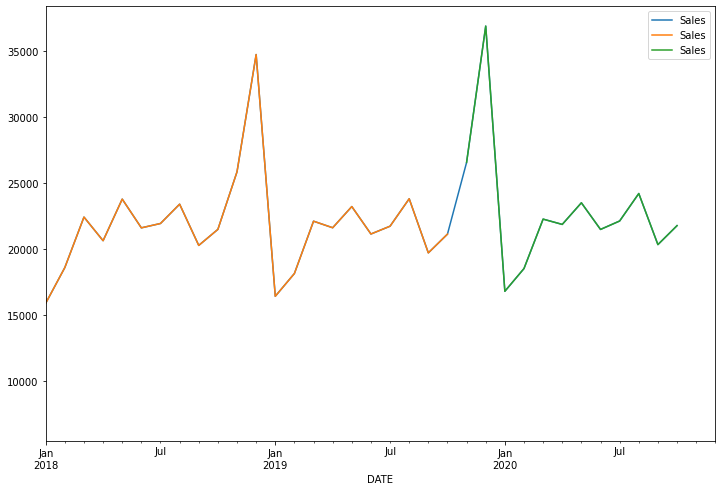

In [181]:
ax = final_df.plot()
ax1 = df.plot(ax = ax)
forecast_df.plot(ax = ax1, figsize = (12, 8))
plt.xlim('2018-01-01', '2020-12-01')